# Group Proposal

#### **Authors:** Linda Huang, Manav Kakar, Omer Tahir, Yuchen Zhang
#### **Group:** 2

## 1. Introduction

1. **Relevant background information** on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal.

2. **Clearly state the question** you will try to answer with your project. Your question should involve one random variable of interest (the response) and one or more explanatory variables. Of the response variable, explain whether your project is focused on prediction, inference, or both.

3. **Identify and describe the dataset** that will be used to answer the question. Remember, this dataset is allowed to contain more variables than you need, in fact, exploring how the different variables in the dataset affect your model, is a crucial part of the project.

4. Also, be sure to **frame your question/objectives in terms of what is already known in the literature**. Be sure to include at least **two scientific publications** that can help frame your study (you will need to include these in the References section).

## 2. Preliminary Results

### 2.1 Loading relevant libraries

In [115]:
library(tidyverse)
library(ggcorrplot)
library(RColorBrewer)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

### 2.2 Reading and Wrangling the dataset from web in R

In [80]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv"

bike_data <- 
#read.csv("data/SeoulBikeData.csv") |>
    read.csv(url, encoding = 'utf-8') |>
    setNames(c("date",
               "bike_count",
               "hour",
               "temperature",
               "humidity",
               "wind_speed",
               "visibility",
               "dew_point_temp",
               "radiation",
               "rain",
               "snow",
               "season",
               "holiday",
               "functional_day")) |>
    filter(functional_day == "Yes") |>
    select(-functional_day)

In [81]:
View(bike_data)

date,bike_count,hour,temperature,humidity,wind_speed,visibility,dew_point_temp,radiation,rain,snow,season,holiday
<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday
01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday
01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0,0,0,Autumn,No Holiday
30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0,0,0,Autumn,No Holiday
30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0,0,0,Autumn,No Holiday


### 2.3 Exploratory Data Analysis

#### 2.3.1 Checking for correlations

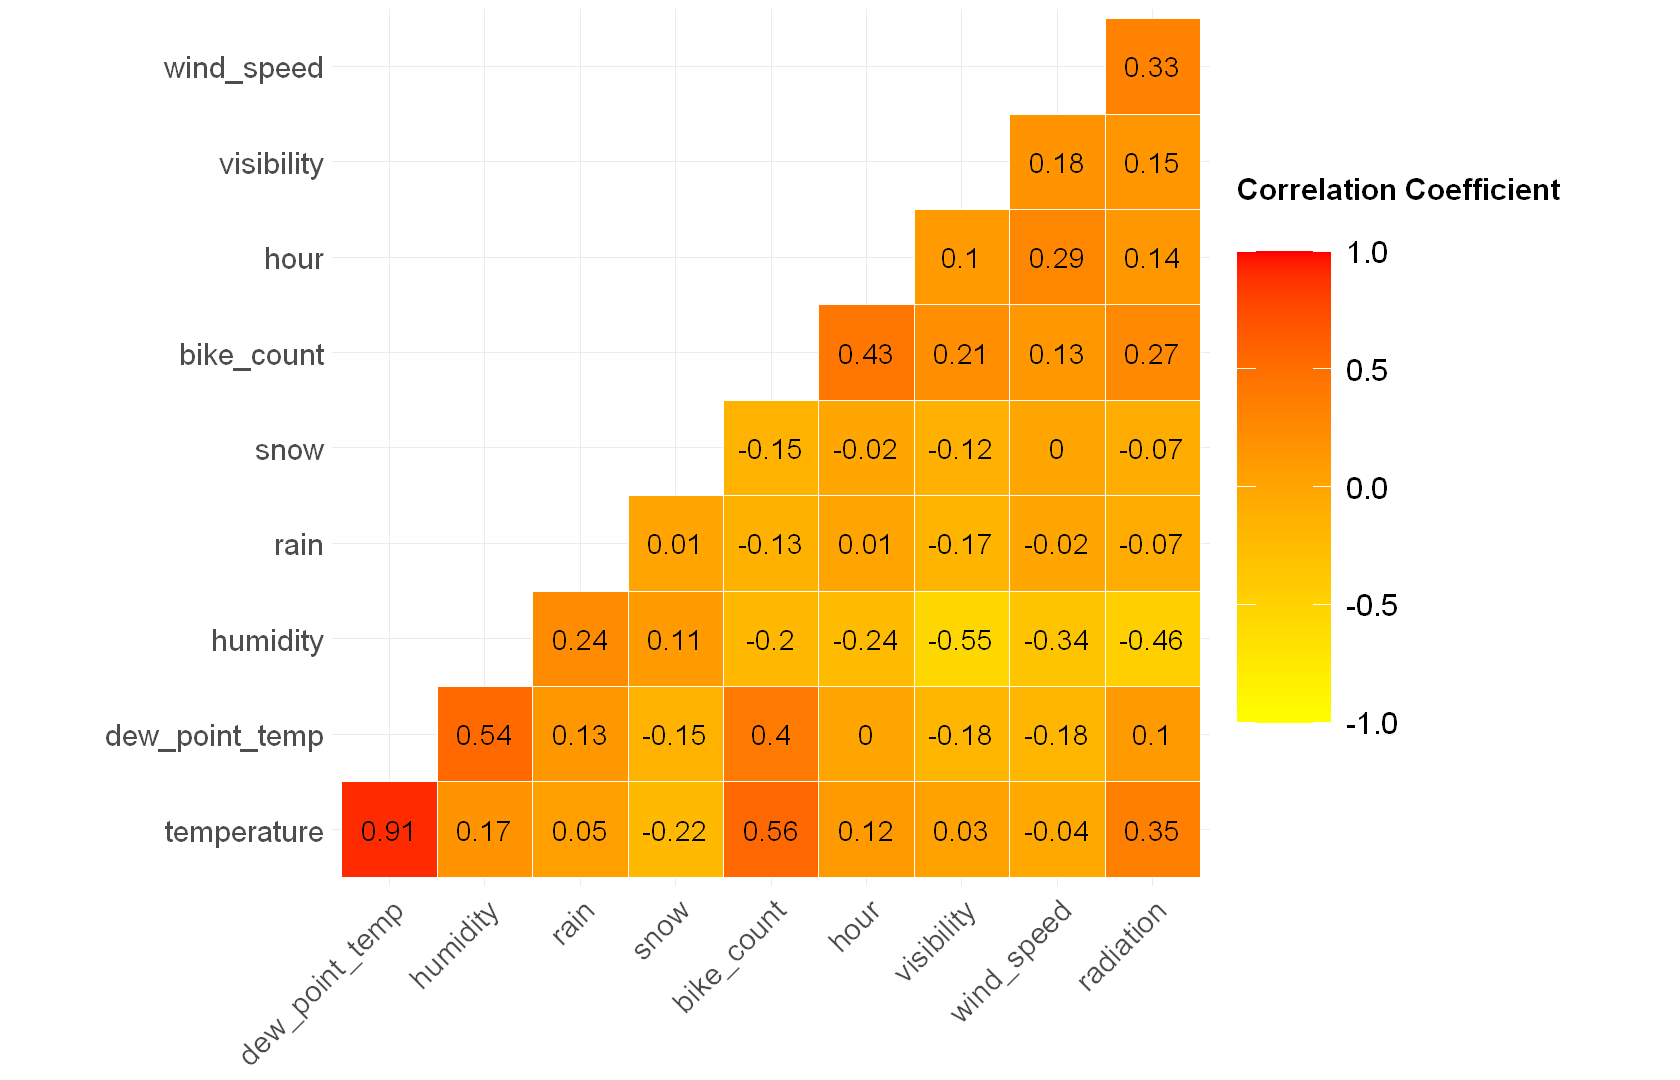

In [59]:
options(repr.plot.width = 14, repr.plot.height = 9)

corr_plot <- 
    bike_data |>
    select(-c(date, season, holiday)) |>
    cor() |>
    round(2) |> 
    ggcorrplot(hc.order = TRUE,
               outline.col = "white",
               type = "lower",
               lab = TRUE,
               lab_size = 6,
               tl.cex = 18,
               colors = c("yellow", "orange", "red"),
               legend.title = "Correlation Coefficient\n") +
    theme(legend.title = element_text(size = 18, face = "bold"),
          legend.text = element_text(size = 18),
          legend.key.size = unit(2, "cm"))

corr_plot

* In general, an absolute correlation coefficient of >0.7 among two or more predictors indicates the presence of multicollinearity.
* This suggests that the variables `dew_point_temp` and `temp` are indicating the presence of multicollinearity since they have a very high correlation of 0.91.

#### 2.3.2 Relation between explanatory variables with high correlation with the response variable

* We observe that `temperature` and `hour` have high correlations with `bike_count`.

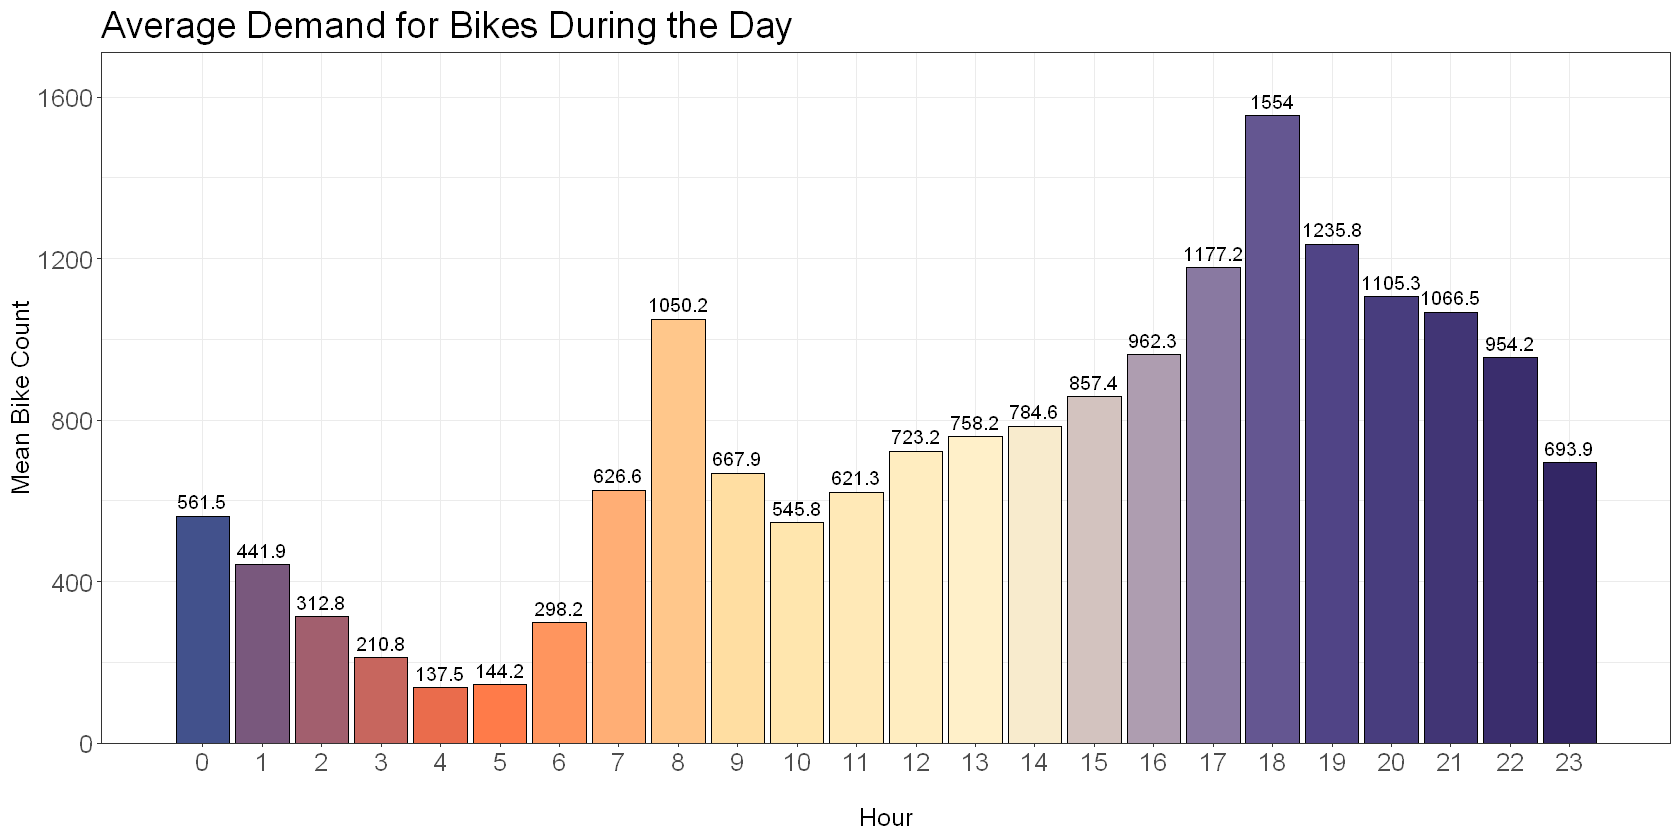

In [166]:
options(repr.plot.width = 14, repr.plot.height = 7)

count_by_hour_plot <- 
    bike_data |>
    group_by(hour) |>
    summarise(mean_bike_count = mean(bike_count)) |>
    ggplot(aes(x = hour, y = mean_bike_count)) +
    geom_bar(aes(fill = hour), color = "black", stat = "identity") +
    scale_fill_gradientn(colors = c("#42518C", "#FF7040", "#FFE3A7", "#FFF3D0", "#54498B", "#332665")) +
    labs(x = "\nHour",
         y = "Mean Bike Count",
         title = "Average Demand for Bikes During the Day") +
    geom_text(aes(label = round(mean_bike_count, 1)), vjust = -0.5, size = 4) +
    scale_x_continuous(limits = c(-0.5, 23.5),
                       breaks = seq(0, 23),
                       minor_breaks = seq(1, 23, 1)) +
    scale_y_continuous(expand = expansion(mult = c(0, .1))) +
    theme_bw() +
    theme(legend.position = "none",
          plot.title = element_text(size = 22),
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 15))

count_by_hour_plot

`geom_smooth()` using formula 'y ~ x'



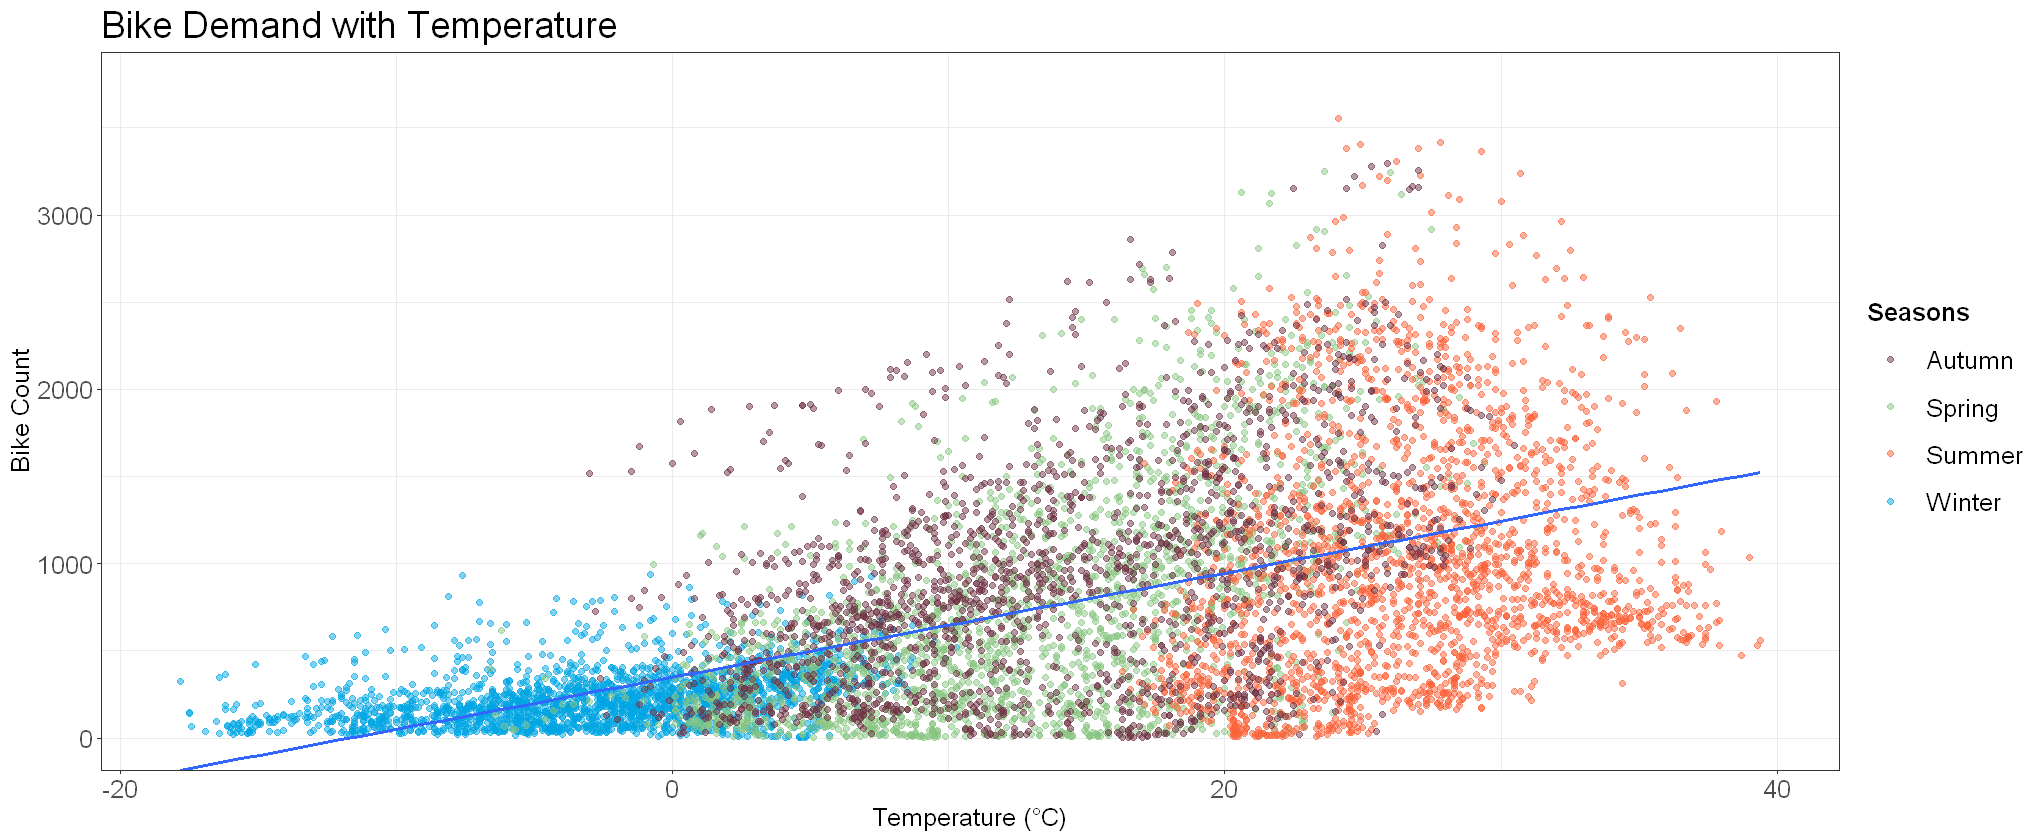

In [218]:
options(repr.plot.width = 17, repr.plot.height = 7)

count_x_temp_plot <-
    bike_data |>
    ggplot(aes(x = temperature, y = bike_count)) +
    geom_point(aes(color = season), alpha = 0.5) +
    scale_colour_manual(values = c("#6E3144", "#88C581", "#FC6238", "#00A5E3")) +
    labs(x = "Temperature (°C)",
         y = "Bike Count",
         color = "Seasons",
         title = "Bike Demand with Temperature") +
    theme_bw() +
    theme(plot.title = element_text(size = 22),
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 15),
          legend.title = element_text(size = 15, face = "bold"),
          legend.text = element_text(size = 15),
          legend.key.size = unit(1, "cm")) +
    geom_smooth(method = "lm", se = FALSE) +
    scale_y_continuous(expand = expansion(mult = c(0, .1)))
    

count_x_temp_plot

In [13]:
options(repr.plot.width = 8, repr.plot.height = 6)

bike_data_3 <- bike_data %>%
              select(- date)%>%
              group_by(season) %>%
              summarise(mean_bike_count= mean(bike_count))

head(bike_data_3)

season,mean_bike_count
<chr>,<dbl>
Autumn,924.1105
Spring,746.2542
Summer,1034.0734
Winter,225.5412


## Methods: Plan

## References